In [77]:
## CNN pytorch training with intelclassification dataset ## test data created from intel classification prediction folder manually
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report

In [78]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [79]:
#Transforms-- for data tranformations
transformer=transforms.Compose([
    transforms.Resize((150,150)), ## resizing for images of same size
    transforms.RandomHorizontalFlip(),## Data Augmentation- Adds variation in dataset
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors for each bands/color channels ## torch require tensor type not numpy
    transforms.Normalize([0.5,0.5,0.5], ## Normalize 0-1 to range [-1,1] , formula (pixel_value-mean)/std deviation ## colums for each channel, rows for mean and sd (which are 0.5 each)
                        [0.5,0.5,0.5]) ## Reduce skewness and learn faster
])

In [80]:
#Dataloader- feeding data in forms of data loader ## folders should be present for the categorises they presents
## validation

#Path for training and validationing directory
train_path="/home/jk/code_learning/Dataset/intelclassification/seg_train"
val_path="/home/jk/code_learning/Dataset/intelclassification/seg_val"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer), ### batch size for hyper parameter for model ## shuffle for model not biased, radomize order of images
    batch_size=64, shuffle=True
)
val_loader=DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transformer),  ### batch size for hyper parameter for model ## shuffle for model not biased, radomize order of images
    batch_size=32, shuffle=True
)

In [81]:
#categories ## fetcing all categories to a list
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']


In [82]:
#CNN Network Class ## we specify all layes in network

class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150) 256-batch size, 3- no of channel (150,150)- H and W of image
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1) # w=150, f= size of fileter Padding =1 stride s=1 ((150-3+2*1)+1=150) New size =150x150 again # out_channel=12
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12) ### batch normalization done
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU() ### activation done
        #Shape= (256,12,150,150)
        
        
        self.pool=nn.MaxPool2d(kernel_size=2) ### max pooling done of size 2, image size will reduce by factor of 2 that is 150/2=75 so 
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1) ## New shape as per above equation
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
                
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes) ## total feature= inupt 32*75*75, no of ouput features = number of ouptput class
        
        
        
        #Feed forwad function for passsing imputs on the above layer
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,75,75)
        # inorder to feed it inside fully connected layer we reshape it to a vector of 32*75*75
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            
        


In [83]:
model=ConvNet(num_classes=6).to(device) ## model sent to device

In [84]:
#Optmizer and loss function Default, you may tune as per requirement
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [85]:
num_epochs=15 ## no of iteration required

In [86]:
#calculating the size of training and validation images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
val_count=len(glob.glob(val_path+'/**/*.jpg'))
print(train_count,val_count)

14034 3000


In [87]:
#Model training and saving best model ## model is not optimized its for just an example

best_accuracy=0.0 ## inititalizing current accuracy as 0, which we will update inside

for epoch in range(num_epochs):  ## for each epoch in training as mentioned earlier
    
    ## Two phases, in one we will do training and then we do on validation set
    
    #Evaluation and training on training dataset 
    model.train()
    train_accuracy=0.0 ## initializing training accuracy and loss to 0
    train_loss=0.0
    
    
    for images,labels in tqdm(train_loader): ## looping over images and labels inside train loader #for i, (images,labels) in tqdm(train_loader):
        if torch.cuda.is_available():  ## if cude available sned images and labels to cuda else it will use cpu
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad() ## since bacward function, accumulate gradients, and we dont want to mixup gradients in the minibatches, gradient set to 0 at the start of minibatch
        
        outputs=model(images) ## gives us the prediction--forward pass y value
        loss=loss_function(outputs,labels) ## compute loss/error using predicted and actual value
        loss.backward() ## back propagation
        optimizer.step() ## update weight and bias using the computed gradients
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)  ## calculating the prediction
        
        train_accuracy+=int(torch.sum(prediction==labels.data)) ## acuuracy calculation
        #print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))
        
    train_accuracy=train_accuracy/train_count  ## outside loop find total training accuracy
    train_loss=train_loss/train_count       ## outside loop find total training loss
    
    
    # Evaluation on validation dataset ## validation
    model.eval()
    val_accuracy=0.0
    val_loss=0.0
    for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images) ## make the predicting on validation data
        
        val_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1) ## getting the category id or class label
        val_accuracy+=int(torch.sum(prediction==labels.data)) ## val accuracy found
        #print('Epoch: '+str(epoch)+' Validation Loss: '+str(val_loss)+' Validation Accuracy: '+str(val_accuracy))
    
    val_accuracy=val_accuracy/val_count ## out of loop total val/validation accuracy
    val_loss=val_loss/val_count       ## outside loop find total val/validation loss
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Val Accuracy: '+str(val_accuracy)+' Val Loss: '+str(val_loss))
    
    #Save the best model ## having better val accuracy
    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=val_accuracy
    
       


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.70it/s]


Epoch: 0 Train Loss: tensor(6.4155) Train Accuracy: 0.5605671939575317 Val Accuracy: 0.5083333333333333 Val Loss: tensor(1.0041)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.16it/s]


Epoch: 1 Train Loss: tensor(2.6472) Train Accuracy: 0.6541969502636454 Val Accuracy: 0.609 Val Loss: tensor(2.3756)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.85it/s]


Epoch: 2 Train Loss: tensor(1.5843) Train Accuracy: 0.7293715262932877 Val Accuracy: 0.625 Val Loss: tensor(1.1091)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.06it/s]


Epoch: 3 Train Loss: tensor(0.9506) Train Accuracy: 0.7845233005557931 Val Accuracy: 0.722 Val Loss: tensor(2.3900)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.98it/s]


Epoch: 4 Train Loss: tensor(0.4465) Train Accuracy: 0.8599828986746473 Val Accuracy: 0.747 Val Loss: tensor(0.2364)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.10it/s]


Epoch: 5 Train Loss: tensor(0.3046) Train Accuracy: 0.9048738777255237 Val Accuracy: 0.7493333333333333 Val Loss: tensor(0.3257)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.66it/s]


Epoch: 6 Train Loss: tensor(0.2514) Train Accuracy: 0.9226877583012684 Val Accuracy: 0.752 Val Loss: tensor(0.3319)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.14it/s]


Epoch: 7 Train Loss: tensor(0.1620) Train Accuracy: 0.9481972352857346 Val Accuracy: 0.7546666666666667 Val Loss: tensor(0.2880)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.11it/s]


Epoch: 8 Train Loss: tensor(0.1701) Train Accuracy: 0.9494085791648853 Val Accuracy: 0.7293333333333333 Val Loss: tensor(0.3461)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 11.96it/s]


Epoch: 9 Train Loss: tensor(0.1352) Train Accuracy: 0.9596693743765142 Val Accuracy: 0.701 Val Loss: tensor(0.3606)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.21it/s]


Epoch: 10 Train Loss: tensor(0.1239) Train Accuracy: 0.9647285164600257 Val Accuracy: 0.7563333333333333 Val Loss: tensor(0.0187)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.22it/s]


Epoch: 11 Train Loss: tensor(0.0951) Train Accuracy: 0.9704289582442639 Val Accuracy: 0.7466666666666667 Val Loss: tensor(0.0450)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:18<00:00, 12.16it/s]


Epoch: 12 Train Loss: tensor(0.1543) Train Accuracy: 0.9563203648282742 Val Accuracy: 0.726 Val Loss: tensor(0.0162)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:17<00:00, 12.23it/s]


Epoch: 13 Train Loss: tensor(0.1570) Train Accuracy: 0.953897677069973 Val Accuracy: 0.7446666666666667 Val Loss: tensor(0.2366)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:17<00:00, 12.31it/s]


Epoch: 14 Train Loss: tensor(0.1125) Train Accuracy: 0.9700014251104461 Val Accuracy: 0.7393333333333333 Val Loss: tensor(0.0360)


In [88]:
## starting stage of Testing
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()
model.cuda() ## transfering model to GPU otherwaise error from testings

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [89]:
#Transforms for testing phase ## avaoiding horizontal flip as images are real world images to test
transformer_test=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [90]:
## setting test path and test data loader
test_path="/home/jk/code_learning/Dataset/intelclassification/seg_test"
test_set=torchvision.datasets.ImageFolder(test_path,transform=transformer_test) ## preparing test set from test path and traformaion
test_loader=DataLoader(test_set,batch_size=10,shuffle=True) ### batch size for hyper parameter for model ## shuffle for model not biased, radomize order of images
test_set.classes

['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']

In [91]:
## showing length of test set, here total no of images in trainset folder
len(test_set)

54

In [92]:
torch.as_tensor(test_set.targets) ## labels of each training images

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5])

In [93]:
lable_count=torch.as_tensor(test_set.targets).bincount() ## tital count of each labels return a tnsor list
lable_count[0] ## first element of lable_count list

tensor(11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'int'>
<class 'torch.Tensor'>
Type of image is <class 'torch.Tensor'>
Type of label is <class 'int'>
Shape of image is torch.Size([3, 150, 150])
Shape of label is torch.Size([])
Label of image is 0


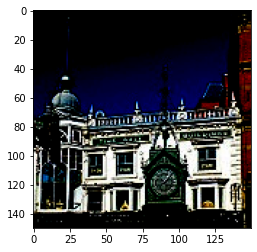

In [94]:
## This code take single image form test_set
sample = next(iter(test_set)) ## next data element in the stream of data.
len(sample) ## next data has image lable pair hence it will print 2
image,label=sample
##printing type of image,lable and shape of image and lable
print(type(label))
print(type(image))
print("Type of image is" +" "+str(type(image)))
print("Type of label is" +" "+str(type(label)))
print("Shape of image is" +" "+str(image.shape)) # OR print(torch.tensor(image).shape)
print("Shape of label is" +" "+str(torch.tensor(label).shape))
## you may use the image.squeeze().shape function to remove [3,150,150] to [150,150]
##plotting one image, Transpose is plotted coz [3,150,150] is an invalid dimention to plot hence [150,150,3] plotted
plt.imshow(torchvision.utils.make_grid(image).permute(1,2,0), cmap="gray")
print("Label of image is",label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len: 2
types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([10, 3, 150, 150]) torch.Size([10])
shapes of first image: torch.Size([3, 150, 150])


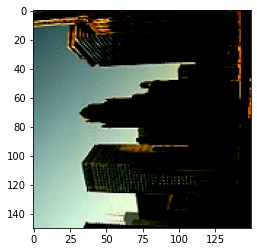

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0
labels: tensor([0, 0, 3, 5, 1, 0, 0, 0, 4, 5])


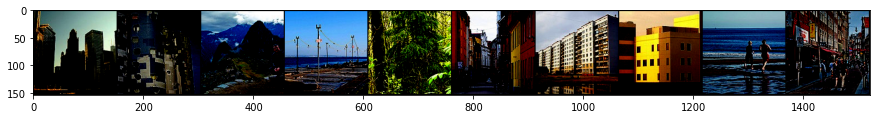

In [95]:
###All the above were done on test_set adn below process are for test_loaded from DataLoader and to see how batch size work
###Batch is loaded and printed, see image shape as 10 of 3x150x150 because of batch size 10
batch = next(iter(test_loader))
print('len:', len(batch))
images, labels = batch
print('types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)
print('shapes of first image:', images[0].shape) ## gives shape of first image, 0-9 index possible if given 10 index error happen
img = images[0].squeeze()
label = labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")
###To plot a batch of images form data loader, we can use the torchvision.utils.make_grid() function to create a grid
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0)) ## OR plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


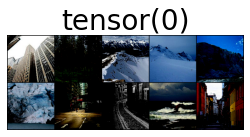

In [96]:
### Another Method to plot
how_many_to_plot = 1
plt.figure(figsize=(50,50))
for i, batch in enumerate(test_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    plt.imshow(torchvision.utils.make_grid(image, nrow=5).permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    lab=label[0]
    plt.title(lab, fontsize=28)
    if (i >= how_many_to_plot): break
plt.show()

In [97]:
#calculating the size of testing images
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(test_count)

53


In [98]:
root=pathlib.Path(test_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']


In [99]:
## setting test path and test data loader
test_path="/home/jk/code_learning/Dataset/intelclassification/seg_test"
test_set=torchvision.datasets.ImageFolder(test_path,transform=transformer_test) ## preparing test set from test path and traformaion
test_loader=DataLoader(test_set,batch_size=1,shuffle=False) ### batch size for hyper parameter for model ## shuffle for model not biased, radomize order of images
test_set.classes

['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']

actual class labels
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
predicted class labels
 [0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 1, 1, 1, 1, 3, 1, 1, 1, 4, 2, 2, 2, 3, 4, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 0, 4, 5, 3]
confusion matrix
 [[9 0 0 0 1 1]
 [0 7 0 1 0 0]
 [0 0 6 1 2 0]
 [0 0 1 7 0 0]
 [0 0 0 0 8 0]
 [1 0 0 1 1 7]]
diagonal elements of confusion matrix
 [9 7 6 7 8 7]
row elements of confusion matrix
 [11  8  9  8  8 10]
class accuracy for each classes
 [0.81818182 0.875      0.66666667 0.875      1.         0.7       ]
             0_buildings  1_forest  2_glacier  3_mountain     4_sea  5_street
0_buildings     1.666667  0.000000   0.000000    0.000000  0.185185  0.185185
1_forest        0.000000  1.296296   0.000000    0.185185  0.000000  0.000000
2_glacier       0.000000  0.000000   1.111111    0.185185  0.370370  0.000000


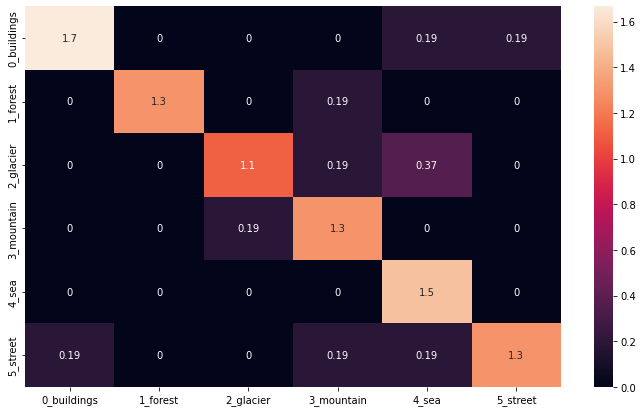

In [100]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    if torch.cuda.is_available():  ## if cude available sned images and labels to cuda else it will use cpu
        images=Variable(inputs.cuda())
        labels=Variable(labels.cuda())
        
    outputs=model(images) # Feed Network

    outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    y_pred.extend(outputs) # Save Prediction
    
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    

print("actual class labels\n",y_true)
print("predicted class labels\n",y_pred)
# constant for classes
classes = ('0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("confusion matrix\n",cf_matrix)
each_class_accuracy=cf_matrix.diagonal()/cf_matrix.sum(axis=1)
print("diagonal elements of confusion matrix\n",cf_matrix.diagonal())
print("row elements of confusion matrix\n",cf_matrix.sum(axis=1))
print("class accuracy for each classes\n", each_class_accuracy) ## printing each class accuracy
#print(printing confusion matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
print(df_cm)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [75]:
test_path="/home/jk/code_learning/Dataset/intelclassification/seg_test"
test_set=torchvision.datasets.ImageFolder(test_path,transform=transformer_test) ## preparing test set from test path and traformaion
test_loader=DataLoader(test_set,batch_size=1,shuffle=False) ### batch size for hyper parameter for model ## shuffle for model not biased, radomize order of images
test_set.classes

['0_buildings', '1_forest', '2_glacier', '3_mountain', '4_sea', '5_street']

In [76]:
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, target_names=['Class 1', 'Class 2', 'Class 3','Class 4', 'Class 5', 'Class 6']))


Classification Report

              precision    recall  f1-score   support

     Class 1       0.89      0.73      0.80        11
     Class 2       0.70      0.88      0.78         8
     Class 3       0.88      0.78      0.82         9
     Class 4       0.70      0.88      0.78         8
     Class 5       0.88      0.88      0.88         8
     Class 6       0.67      0.60      0.63        10

    accuracy                           0.78        54
   macro avg       0.78      0.79      0.78        54
weighted avg       0.79      0.78      0.78        54



In [ ]:
##### not required


test_accuracy=0.0
test_loss=0.0
## variables for testing classwaise accuracy
buildings=torch.tensor(0)
forest=torch.tensor(1)
glacier=torch.tensor(2)
mountain=torch.tensor(3)
sea=torch.tensor(4)
street=torch.tensor(5)
###############################
tot_buildings=0
pred_buildings=0
tot_forest=0
pred_forest=0
tot_glacier=0
pred_glacier=0
tot_mountain=0
pred_mountain=0
tot_sea=0
pred_sea=0
tot_street=0
pred_street=0
###############################

for i, (images,labels) in enumerate(test_loader): ## looping over images and labels inside test loader
    if torch.cuda.is_available():  ## if cude available sned images and labels to cuda else it will use cpu
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
    
    ##print(labels.data) print lables of each data
    
    if(labels.data==buildings):
        tot_buildings=tot_buildings+1
    if(labels.data==forest):
        tot_forest=tot_forest+1
    if(labels.data==glacier):
        tot_glacier=tot_glacier+1
    if(labels.data==mountain):
        tot_mountain=tot_mountain+1
    if(labels.data==sea):
        tot_sea=tot_sea+1
    if(labels.data==street):
        tot_street=tot_street+1
        
    outputs=model(images) ## make the predicting on validation data
    #print(outputs.shape)
        
    test_loss+= loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1) ## getting the category id or class label## taking maximum probablity of each classes 
    #print(prediction)
    #print(int((prediction==labels.data)))
    test_accuracy+=int(torch.sum(prediction==labels.data)) ## val accuracy found
    
   
test_accuracy=test_accuracy/test_count ## out of loop total val/validation accuracy
test_loss=test_loss/test_count       ## outside loop find total val/validation loss
    

print("Total number of building images in test set = ",tot_buildings)
print("Total number of forest images in test set = ",tot_forest)
print("Total number of glacier images in test set = ",tot_glacier)
print("Total number of mountain images in test set = ",tot_mountain)
print("Total number of sea images in test set = ",tot_sea)
print("Total number of street images in test set = ",tot_street)


print('Epoch: '+str(epoch)+' Test Loss: '+str(test_loss)+' Test Accuracy: '+str(test_accuracy))